In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TITANIC_PATH = os.path.join('datasets', 'titanic')

In [3]:
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [5]:
train_data = load_titanic_data('train.csv')
test_data = load_titanic_data('test.csv')

In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Survived: that's the target, 0 means the passenger did not survive, while 1 means \
he/she survived.\
Pclass: passenger class.\
Name, Sex, Age: self-explanatory\
SibSp: how many 兄弟 & 配偶者 of the passenger aboard the Titanic.\
Parch: how many children & parents of the passenger aboard the Titanic.\
Ticket: ticket id\
Fare: price paid (in pounds)\
Cabin: passenger's cabin number\
Embarked: where the passenger embarked the Titanic\

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(['Age', 'SibSp', 'Parch', 'Fare'])),
    ('imputer', SimpleImputer(strategy='median'))
])

In [15]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series(
            [ X[c].value_counts().index[0] for c in X],
            index = X.columns
        )
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
cat_pipeline = Pipeline([
    ('select_cat', DataFrameSelector(['Pclass', 'Sex', 'Embarked'])),
    ('imuter', MostFrequentImputer()),
    ('cat_encoder', OneHotEncoder(sparse=False))
])

In [19]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [20]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [21]:
y_train = train_data['Survived']

In [22]:
from sklearn.svm import SVC
svm_clf = SVC(gamma='auto')
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

In [23]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

In [24]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

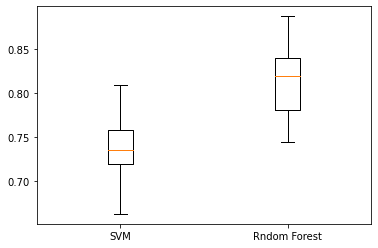

In [30]:
plt.boxplot([svm_scores, forest_scores], labels=('SVM', 'Rndom Forest'))
plt.show()

In [39]:
#15歳ごとに分ける
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [40]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


# 自習

In [82]:
df_train = train_data.copy()
df_train = df_train.drop(['Age','SibSp', 'Parch'], axis=1)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       891 non-null    int64  
 1   Survived          891 non-null    int64  
 2   Pclass            891 non-null    int64  
 3   Name              891 non-null    object 
 4   Sex               891 non-null    object 
 5   Ticket            891 non-null    object 
 6   Fare              891 non-null    float64
 7   Cabin             204 non-null    object 
 8   Embarked          889 non-null    object 
 9   AgeBucket         714 non-null    float64
 10  RelativesOnboard  891 non-null    int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [83]:
test_data["AgeBucket"] = test_data["Age"] // 15 * 15
test_data["RelativesOnboard"] = test_data["SibSp"] + test_data["Parch"]
df_test = test_data.copy()
df_test = df_test.drop(['Age','SibSp', 'Parch'], axis=1)

In [84]:
num_pipeline_2 = Pipeline([
    ('select_numeric', DataFrameSelector(['Fare', 'AgeBucket'])),
    ('imputer', SimpleImputer(strategy='median'))
])

cat_pipeline_2 = Pipeline([
    ('select_cat', DataFrameSelector(['Pclass', 'Sex', 'Embarked',
                                      'AgeBucket', 'RelativesOnboard'])),
    ('imuter', MostFrequentImputer()),
    ('cat_encoder', OneHotEncoder(sparse=False))
])


preprocess_pipeline_2 = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline_2', cat_pipeline),
])

In [85]:
X_train_2 = preprocess_pipeline_2.fit_transform(df_train)

In [86]:
svm_clf_2 = SVC(gamma="auto")
svm_clf_2.fit(X_train_2, y_train)

SVC(gamma='auto')

In [87]:
X_test_2 = preprocess_pipeline_2.transform(df_test)
y_pred_2 = svm_clf_2.predict(X_test_2)

In [89]:
svm_scores = cross_val_score(svm_clf_2, X_train_2, y_train, cv=10)
svm_scores.mean()

0.7565543071161048

In [91]:
forest_clf_2 = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores_2 = cross_val_score(forest_clf_2,X_train_2, y_train, cv=10)
forest_scores_2.mean()

0.8103745318352061